## Week 11 notebook

For Week 11, include concepts such as density-based spatial clustering of applications with noise (DBSCAN), hierarchical agglomerative clustering (HAC), linkage methods in HAC, and dendrograms. Complete your Jupyter Notebook homework by 11:59pm ET on Sunday. 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Import feature engineering and selection libraries
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.neighbors import NearestNeighbors

# data preprocesing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Classification metrics
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, f1_score, classification_report, silhouette_score, make_scorer

random_state = 0

In [3]:
def encoding(df_or_series, cat_cols: list = None, one_hot: bool = False):
    """
    Encodes categorical columns in a DataFrame or a single pandas Series.

    Args:
        df_or_series: DataFrame or Series to encode.
        cat_cols: List of columns to encode (only used if input is DataFrame).
        one_hot: If True, use one-hot encoding for DataFrame input.

    Returns:
        If input is DataFrame: (encoded DataFrame, mappings dict or list of new columns)
        If input is Series: (encoded Series, mapping dict)
    """
    if isinstance(df_or_series, pd.Series):
        uniques = df_or_series.dropna().unique().tolist()
        mapping = {cat: code for code, cat in enumerate(uniques)}
        encoded = df_or_series.map(mapping).astype("int64")
        return encoded
    
    elif isinstance(df_or_series, pd.DataFrame):
        if one_hot:
            if cat_cols is None:
                cat_cols = df_or_series.select_dtypes(include=['object', 'category']).columns.tolist()
            df_encoded = pd.get_dummies(df_or_series, columns=cat_cols, drop_first=True)
            return df_encoded
        else:
            df_encoded = df_or_series.copy()
            mappings = {}
            if cat_cols is None:
                cat_cols = df_encoded.select_dtypes(include=['object', 'category']).columns.tolist()
            for col in cat_cols:
                uniques = df_encoded[col].dropna().unique().tolist()
                mapping = {cat: code for code, cat in enumerate(uniques)}
                mappings[col] = mapping
                df_encoded[col] = df_encoded[col].map(mapping).astype("int64")
            return df_encoded
    
    else:
        raise ValueError("Input must be a pandas DataFrame or Series.")

In [4]:
def load_and_split_data(file_path: str, target_col: str = None, one_hot: bool = False, test_size: float = 0.2, random_state: int = 0, scaling: str = 'norm'):
    """
    Loads data, encodes categorical features, splits into train/test, and scales features.

    Args:
        file_path: Path to CSV file.
        target_col: Name of target column. If None, uses last column.
        test_size: Fraction for test split.
        random_state: Random seed.
        scaling: 'norm' (MinMax), 'reg' (Standard), or None.

    Returns:
        X_train, X_test, y_train, y_test, df, mappings
    """
    df = pd.read_csv(file_path)
    
    # Select target
    if target_col is None:
        target_col = df.columns[-1]
    X = df.drop(columns=[target_col])
    y = df[target_col]

    # Encode Categorical Features
    if one_hot is True:
        X_encoded = encoding(X, one_hot=True)
        if y.dtype == 'object' or y.dtype.name == 'category':
            y_encoded = encoding(y)
        else:
            y_encoded = y
    else:
        X_encoded = encoding(X)
        if y.dtype == 'object' or y.dtype.name == 'category':
            y_encoded = encoding(y)
        else:
            y_encoded = y
            
        

    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X_encoded, y_encoded, test_size=test_size, random_state=random_state
    )

    # Reset indices
    X_train = X_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)

    # Scaling
    if scaling == 'reg':
        scaler = StandardScaler()
    elif scaling == 'norm':
        scaler = MinMaxScaler()
    else:
        scaler = None

    if scaler is not None:
        X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
        X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

    return X_train, X_test, y_train, y_test, df


In [5]:
# Load the ins claims dataset with variations of encoding and scaling
X_train_ins_oh_reg, X_test_ins_oh_reg, y_train_ins_oh_reg, y_test_ins_oh_reg, df_ins_oh_reg = load_and_split_data(
    r'C:\Users\JT von Seggern\DS Masters Repos\2025-spring-B2\data\insurance_claims_cleaned.csv', 
    target_col='fraud_reported', one_hot=False, scaling='reg')

# Load the car claims dataset with variations of encoding and scaling
X_train_car_oh_reg, X_test_car_oh_reg, y_train_car_oh_reg, y_test_car_oh_reg, df_car_oh_reg = load_and_split_data(
    r'C:\Users\JT von Seggern\DS Masters Repos\2025-spring-B2\data\carclaims_cleaned.csv', 
    target_col='FraudFound', one_hot=False, scaling='reg')

## Insurance claims

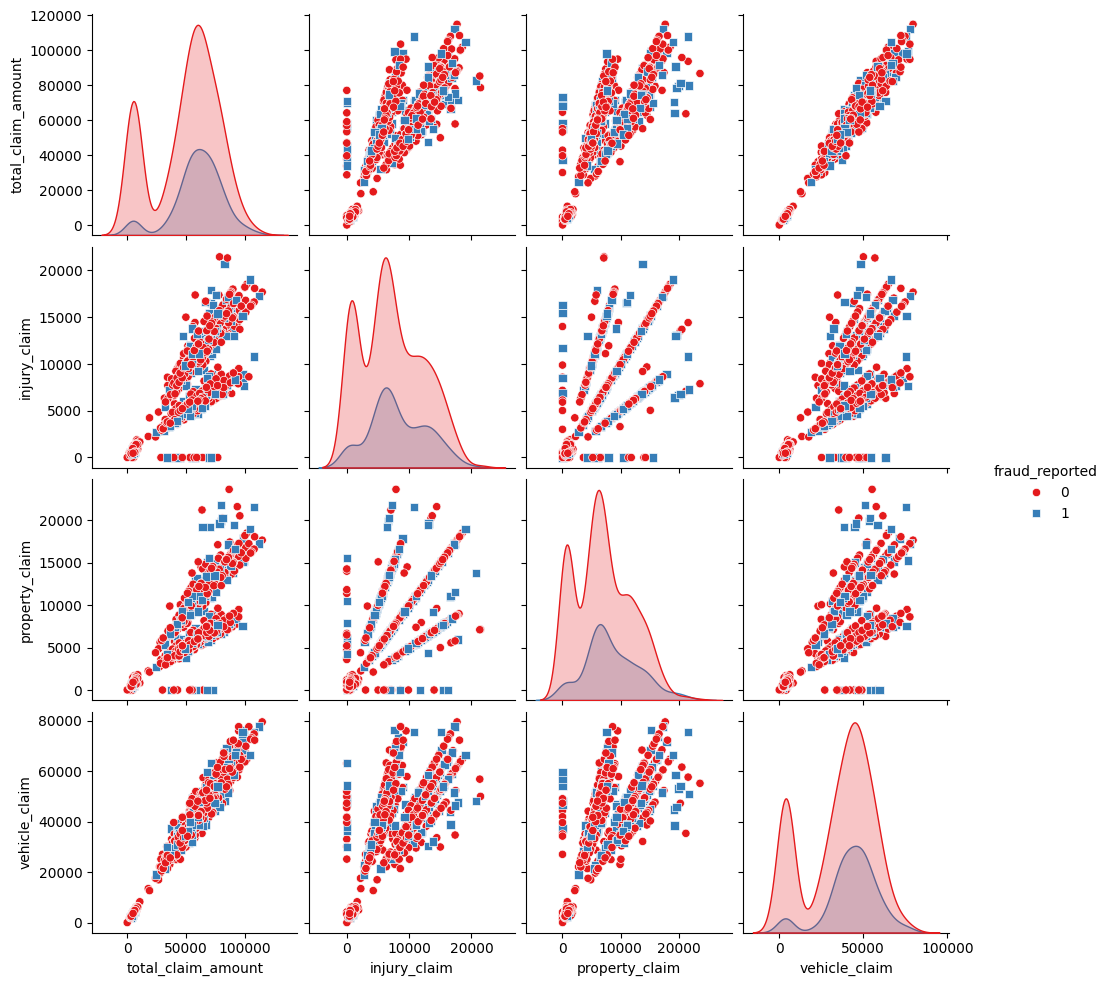

In [6]:
# plotting columns for possible DBSCAN clustering
sns.pairplot(df_ins_oh_reg[['total_claim_amount','injury_claim','property_claim','vehicle_claim','fraud_reported']], hue='fraud_reported', diag_kind='kde', markers=["o", "s"], palette="Set1")

In [7]:
X_train_ins_oh_reg.head()

,months_as_customer,age,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,...,bodily_injuries,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year
0,-0.094195,0.199690,1.219907,-1.185366,-1.021723,-0.209017,-0.489168,1.573417,-1.069940,1.446553,...,-1.211098,0.443634,-0.070821,1.646300,1.307162,2.720780,1.263562,-1.570687,-1.165930,-1.030921
1,-1.749713,-1.097348,-1.183851,1.284146,-1.021723,-1.642830,-0.489168,1.569318,0.934632,1.446553,...,1.223270,1.339864,-1.302488,1.299671,0.108737,3.366941,0.922620,1.402809,0.952940,-0.365945
2,-1.029177,-1.529694,0.018028,-1.185366,-1.021723,0.017655,-0.489168,-0.855134,0.934632,1.446553,...,1.223270,0.443634,-0.070821,-1.788022,-1.324834,-1.340510,-1.810751,-0.331731,1.659230,-0.033457
3,0.206028,-0.232656,0.018028,1.284146,-0.200237,0.317038,-0.489168,-0.932922,0.934632,-0.047949,...,-1.211098,0.443634,-1.302488,0.073345,0.527464,0.519275,-0.166586,-1.570687,-1.165930,-0.199701
4,0.386163,0.307776,0.018028,0.049390,-1.021723,-0.817514,-0.489168,-0.597316,-1.069940,0.450219,...,0.006086,-0.452596,-0.070821,0.843461,1.286535,-0.126887,0.878542,0.411643,1.394371,0.631520


C:\Users\JT von Seggern\AppData\Local\Temp\ipykernel_21312\3959979633.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


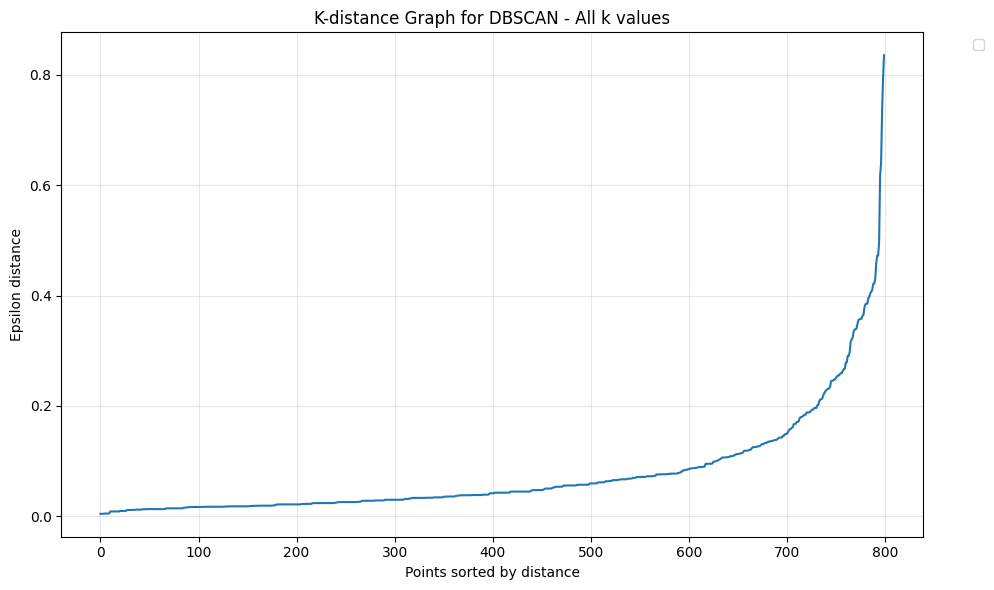

In [8]:
# Create a single figure for all k-distance plots
plt.figure(figsize=(10, 6))

# Run the Nearest Neighbors algorithm to find the optimal epsilon for DBSCAN
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X_train_ins_oh_reg[['vehicle_claim', 'property_claim']])

# Find the distances and indices of the nearest neighbors
distances, indices = neighbors_fit.kneighbors(X_train_ins_oh_reg[['vehicle_claim', 'property_claim']])

# Sort the distances to find the optimal epsilon
distances = np.sort(distances, axis=0)
distances = distances[:, 4]
# Add labels, title, and legend
plt.plot(distances)
plt.xlabel('Points sorted by distance')
plt.ylabel('Epsilon distance')
plt.title('K-distance Graph for DBSCAN - All k values')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### DBSCAN

In [9]:
# DBSCAN clustering
dbscan = DBSCAN(eps=.2, min_samples=5).fit(X_train_ins_oh_reg[['vehicle_claim', 'property_claim']])

# Extract the clusters labels
clusters = dbscan.labels_

# Create a DataFrame to hold the clusters and the original data
clustered_data = X_train_ins_oh_reg.copy()
clustered_data['Cluster'] = clusters

# Display the first few rows of the clustered data
clustered_data.head()

,months_as_customer,age,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,...,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,Cluster
0,-0.094195,0.199690,1.219907,-1.185366,-1.021723,-0.209017,-0.489168,1.573417,-1.069940,1.446553,...,0.443634,-0.070821,1.646300,1.307162,2.720780,1.263562,-1.570687,-1.165930,-1.030921,-1
1,-1.749713,-1.097348,-1.183851,1.284146,-1.021723,-1.642830,-0.489168,1.569318,0.934632,1.446553,...,1.339864,-1.302488,1.299671,0.108737,3.366941,0.922620,1.402809,0.952940,-0.365945,-1
2,-1.029177,-1.529694,0.018028,-1.185366,-1.021723,0.017655,-0.489168,-0.855134,0.934632,1.446553,...,0.443634,-0.070821,-1.788022,-1.324834,-1.340510,-1.810751,-0.331731,1.659230,-0.033457,0
3,0.206028,-0.232656,0.018028,1.284146,-0.200237,0.317038,-0.489168,-0.932922,0.934632,-0.047949,...,0.443634,-1.302488,0.073345,0.527464,0.519275,-0.166586,-1.570687,-1.165930,-0.199701,1
4,0.386163,0.307776,0.018028,0.049390,-1.021723,-0.817514,-0.489168,-0.597316,-1.069940,0.450219,...,-0.452596,-0.070821,0.843461,1.286535,-0.126887,0.878542,0.411643,1.394371,0.631520,2


C:\Users\JT von Seggern\AppData\Local\Temp\ipykernel_21312\1032867419.py:1: UserWarning: 
The markers list has fewer values (5) than needed (8) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(data=clustered_data, x='vehicle_claim', y='property_claim', hue='Cluster', palette='Set1', style='Cluster', markers=["o", "s", "D", "X", "P"], alpha=0.7)


<Axes: xlabel='vehicle_claim', ylabel='property_claim'>

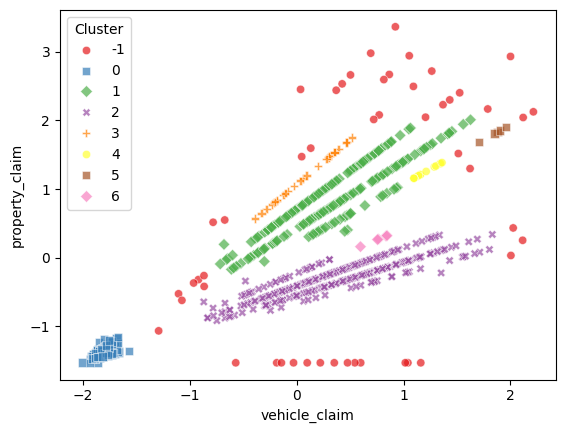

In [10]:
sns.scatterplot(data=clustered_data, x='vehicle_claim', y='property_claim', hue='Cluster', palette='Set1', style='Cluster', markers=["o", "s", "D", "X", "P"], alpha=0.7)

<Axes: xlabel='vehicle_claim', ylabel='property_claim'>

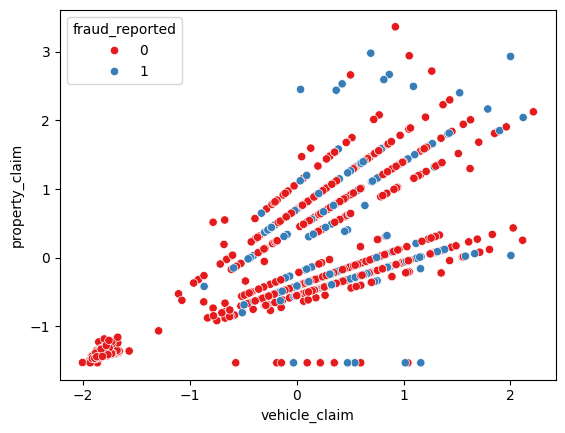

In [11]:
# plotting columns for possible DBSCAN clustering
sns.scatterplot(X_train_ins_oh_reg, x='vehicle_claim', y='property_claim', hue=y_train_ins_oh_reg, markers=["o", "s"], palette="Set1")

### HAC

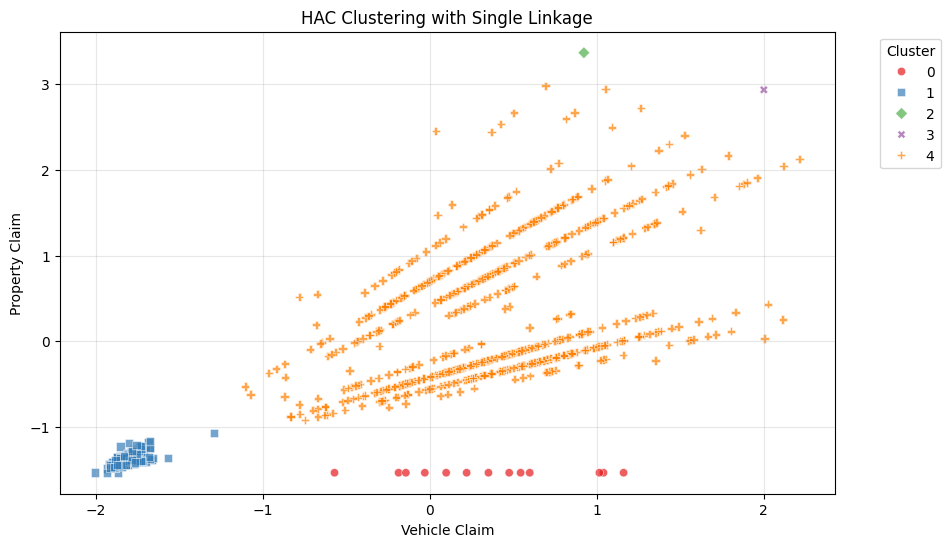

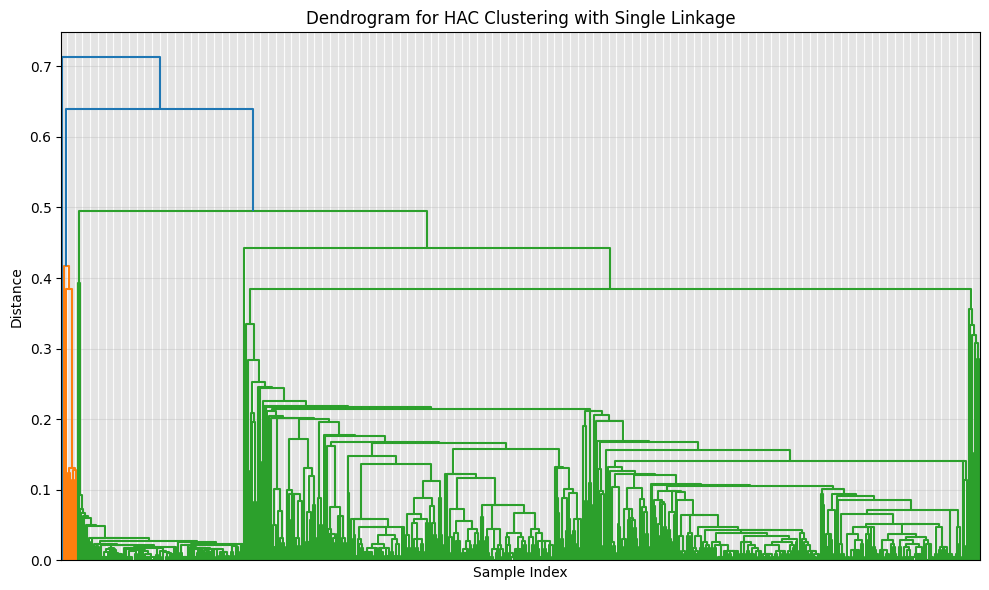

In [ ]:
# HAC-single

# HAC clustering with different linkage methods
hac_single = AgglomerativeClustering(n_clusters=5, linkage='single')
labels_single = hac_single.fit_predict(X_train_ins_oh_reg[['vehicle_claim', 'property_claim']])

# Plot the clusters
plt.figure(figsize=(10,6))
sns.scatterplot(X_train_ins_oh_reg, x='vehicle_claim', y='property_claim', hue=labels_single, palette='Set1', style=labels_single, markers=["o", "s", "D", "X", "P"], alpha=0.7)
plt.xlabel("Vehicle Claim")
plt.ylabel("Property Claim")
plt.title("HAC Clustering with Single Linkage")
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

# Compute the linkage matrix
linkage_matrix_single = linkage(X_train_ins_oh_reg[['vehicle_claim', 'property_claim']], method='single')

# Plot the dendrogram
plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix_single, labels=labels_single)
plt.title("Dendrogram for HAC Clustering with Single Linkage")
plt.xlabel("Sample Index")
plt.xticks(visible=False)
plt.ylabel("Distance")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

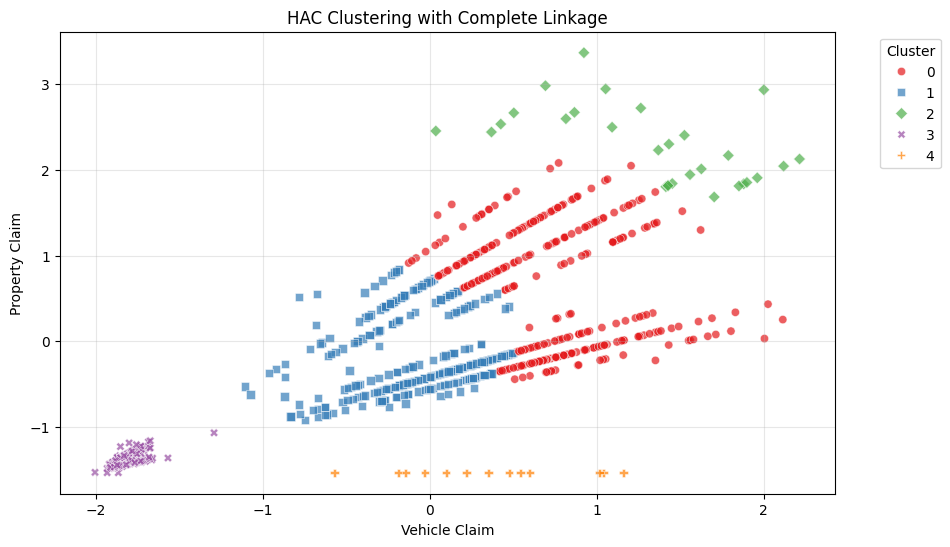

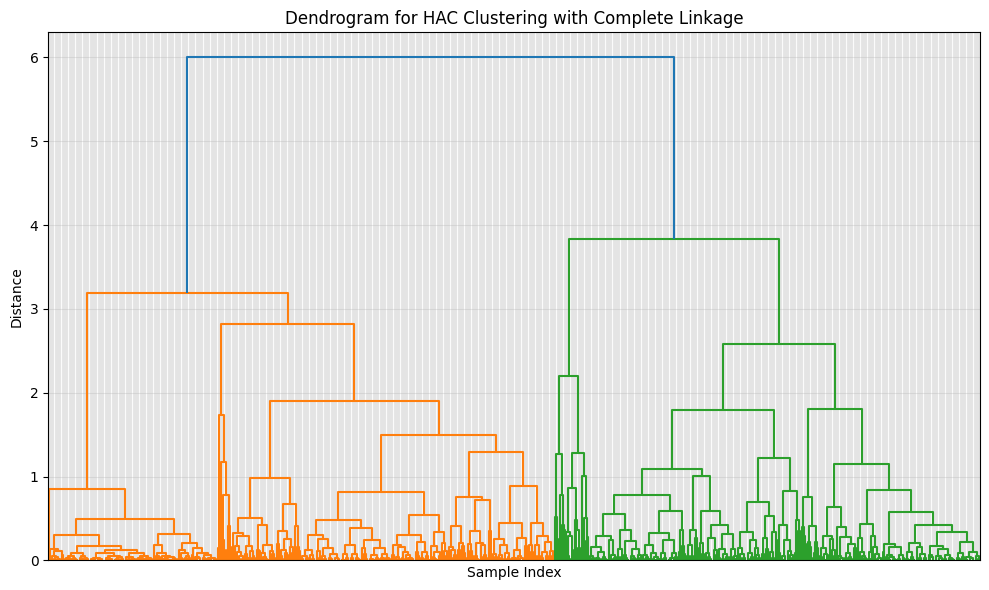

In [13]:
# HAC-complete

# HAC clustering with different linkage methods
hac_complete = AgglomerativeClustering(n_clusters=5, linkage='complete')
labels_complete = hac_complete.fit_predict(X_train_ins_oh_reg[['vehicle_claim', 'property_claim']])

# Plot the clusters
plt.figure(figsize=(10,6))
sns.scatterplot(X_train_ins_oh_reg, x='vehicle_claim', y='property_claim', hue=labels_complete, palette='Set1', style=labels_complete, markers=["o", "s", "D", "X", "P"], alpha=0.7)
plt.xlabel("Vehicle Claim")
plt.ylabel("Property Claim")
plt.title("HAC Clustering with Complete Linkage")
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

# Compute the linkage matrix
linkage_matrix_complete = linkage(X_train_ins_oh_reg[['vehicle_claim', 'property_claim']], method='complete')

# Plot the dendrogram
plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix_complete)
plt.title("Dendrogram for HAC Clustering with Complete Linkage")
plt.xlabel("Sample Index")
plt.xticks(visible=False)
plt.ylabel("Distance")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

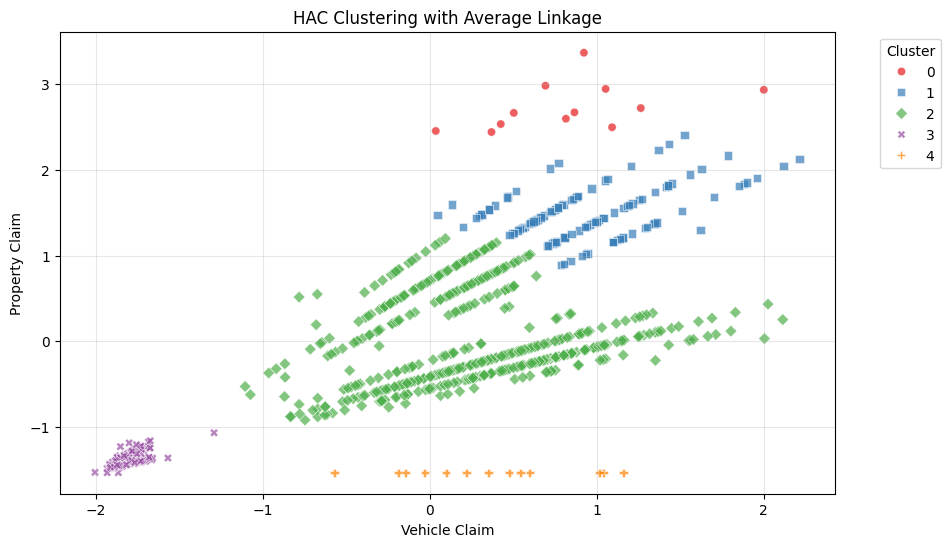

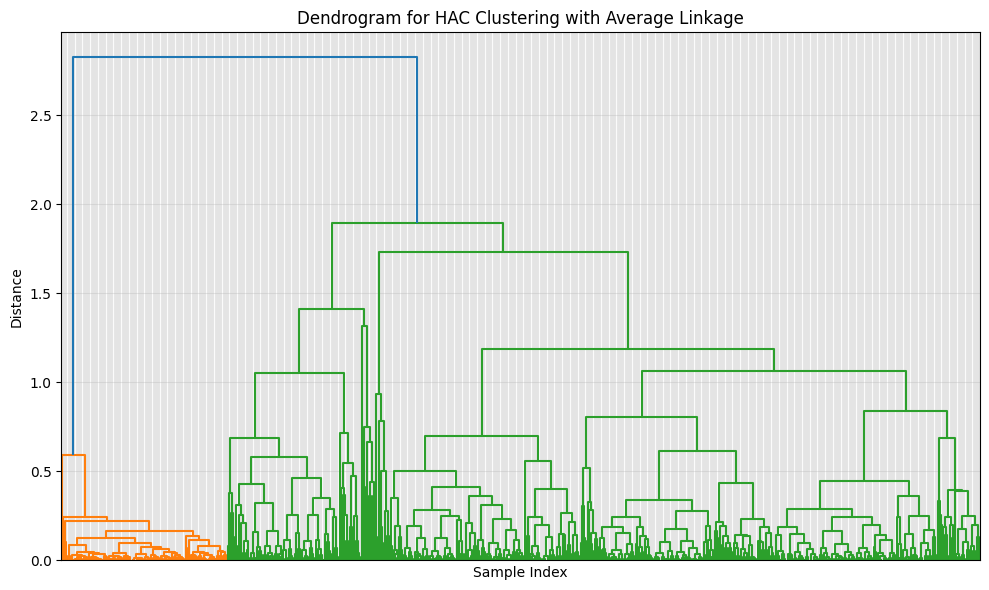

In [14]:
# HAC-average

# HAC clustering with different linkage methods
hac_average = AgglomerativeClustering(n_clusters=5, linkage='average')
labels_average = hac_average.fit_predict(X_train_ins_oh_reg[['vehicle_claim', 'property_claim']])

# Plot the clusters
plt.figure(figsize=(10,6))
sns.scatterplot(X_train_ins_oh_reg, x='vehicle_claim', y='property_claim', hue=labels_average, palette='Set1', style=labels_average, markers=["o", "s", "D", "X", "P"], alpha=0.7)
plt.xlabel("Vehicle Claim")
plt.ylabel("Property Claim")
plt.title("HAC Clustering with Average Linkage")
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

# Compute the linkage matrix
linkage_matrix_average = linkage(X_train_ins_oh_reg[['vehicle_claim', 'property_claim']], method='average')

# Plot the dendrogram
plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix_average)
plt.title("Dendrogram for HAC Clustering with Average Linkage")
plt.xlabel("Sample Index")
plt.xticks(visible=False)
plt.ylabel("Distance")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

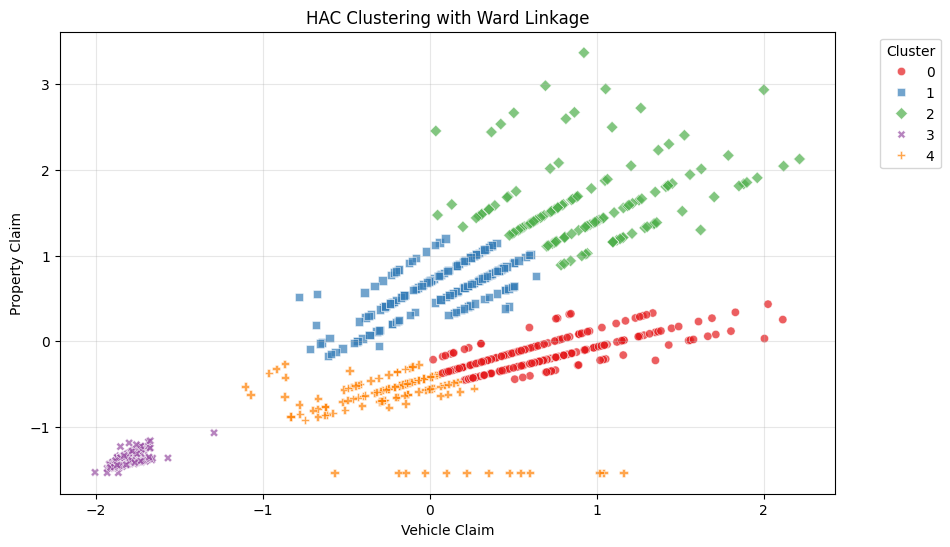

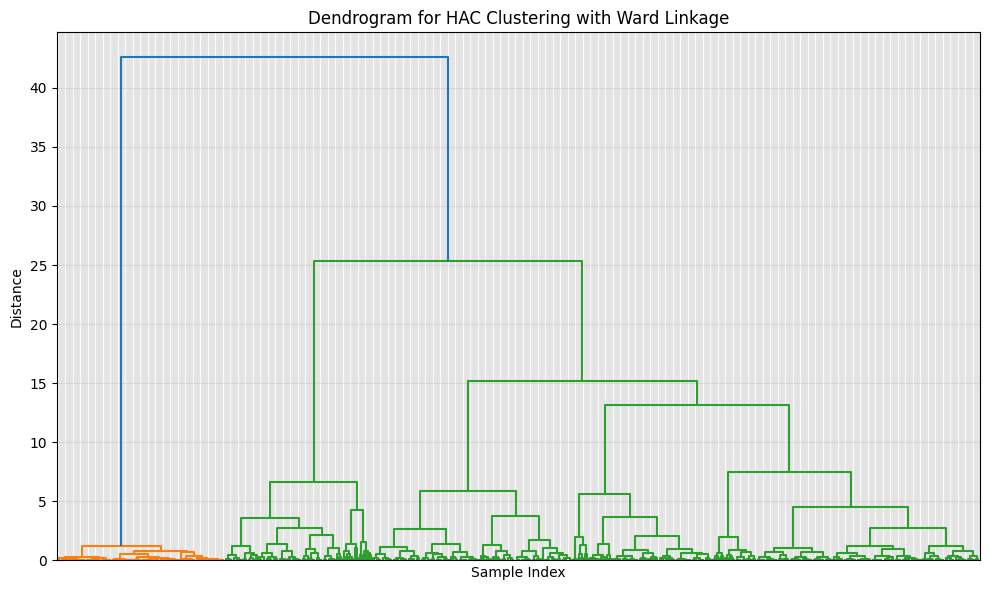

In [15]:
# HAC-ward

# HAC clustering with different linkage methods
hac_ward = AgglomerativeClustering(n_clusters=5, linkage='ward')
labels_ward = hac_ward.fit_predict(X_train_ins_oh_reg[['vehicle_claim', 'property_claim']])

# Plot the clusters
plt.figure(figsize=(10,6))
sns.scatterplot(X_train_ins_oh_reg, x='vehicle_claim', y='property_claim', hue=labels_ward, palette='Set1', style=labels_ward, markers=["o", "s", "D", "X", "P"], alpha=0.7)
plt.xlabel("Vehicle Claim")
plt.ylabel("Property Claim")
plt.title("HAC Clustering with Ward Linkage")
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

# Compute the linkage matrix
linkage_matrix_ward = linkage(X_train_ins_oh_reg[['vehicle_claim', 'property_claim']], method='ward')

# Plot the dendrogram
plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix_ward)
plt.title("Dendrogram for HAC Clustering with Ward Linkage")
plt.xlabel("Sample Index")
plt.xticks(visible=False)
plt.ylabel("Distance")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()